# Testing of queue imbalance for stock 9095

Order of this notebook is as follows:
1. [Data](#Data)
2. [Data visualization](#Data-visualization)
3. [Tests](#Tests)
4. [Conclusions](#Conclusions)

Goal is to implement queue imbalance predictor from [[1]](#Resources).

In [1]:
%matplotlib inline
import pandas as pd

from typing import Tuple
from datetime import datetime

import matplotlib.pyplot as plt

import matplotlib.dates as md
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
import warnings


import lob

warnings.filterwarnings('ignore')

## Data

Market is open between 8-16 on every weekday. We decided to use data from only 9-15 for each day.

### Test and train data

For training data we used data from 2013-09-01 - 2013-11-16:

* 0916
* 1001
* 1016
* 1101

The data from 09-01 is the test data.

In [2]:
df, df_test = lob.load_data('9065')
df.head()

Training set length: 10320
Testing set length: 2563


,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2013-09-16 09:00:00,"[(980.0, 500.0), (1000.0, 5000.0), (1110.0, 26...","[(1618.5, 2288.0), (1619.0, 3603.0), (1619.5, ...",1618.0,1618.5,1618.25,2288.0,10762.0,1.0,0.649349
2013-09-16 09:01:00,"[(980.0, 500.0), (1000.0, 5000.0), (1110.0, 26...","[(1619.0, 3491.0), (1619.5, 10303.0), (1620.0,...",1618.0,1619.0,1618.50,3491.0,10559.0,1.0,0.503060
2013-09-16 09:03:00,"[(980.0, 500.0), (1000.0, 5000.0), (1110.0, 26...","[(1619.5, 5441.0), (1620.0, 10119.0), (1620.5,...",1618.5,1619.5,1619.00,5441.0,4857.0,0.0,-0.056710
2013-09-16 09:04:00,"[(980.0, 500.0), (1000.0, 5000.0), (1110.0, 26...","[(1619.0, 6320.0), (1619.5, 13193.0), (1620.0,...",1618.0,1619.0,1618.50,6320.0,16674.0,1.0,0.450291
2013-09-16 09:05:00,"[(980.0, 500.0), (1000.0, 5000.0), (1110.0, 26...","[(1619.0, 604.0), (1619.5, 13668.0), (1620.0, ...",1618.5,1619.0,1618.75,604.0,6495.0,1.0,0.829835


## Data visualization

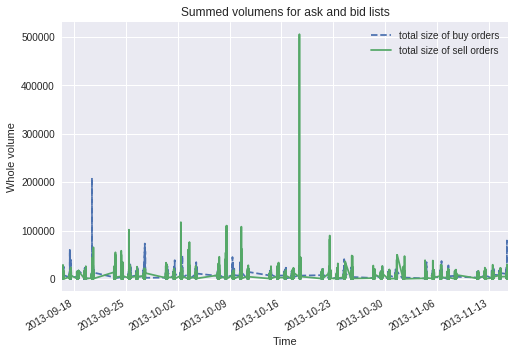

In [3]:
df['sum_buy_bid'].plot(label='total size of buy orders', style='--')
df['sum_sell_ask'].plot(label='total size of sell orders', style='-')
plt.title('Summed volumens for ask and bid lists')
plt.xlabel('Time')
plt.ylabel('Whole volume')
plt.legend()

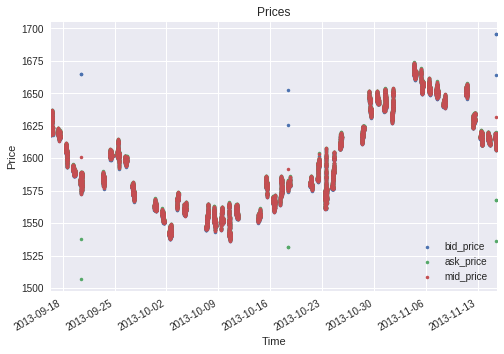

In [4]:
df[['bid_price', 'ask_price', 'mid_price']].plot(style='.')
plt.legend()
plt.title('Prices')
plt.xlabel('Time')
plt.ylabel('Price')

[]

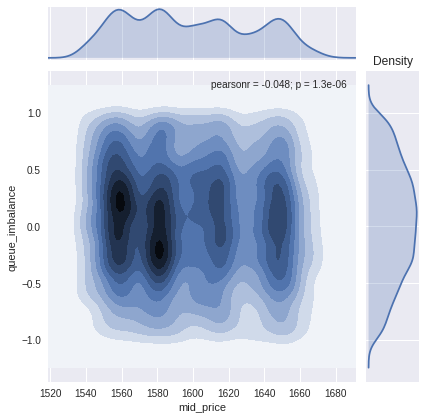

In [5]:
sns.jointplot(x="mid_price", y="queue_imbalance", data=df.loc[:, ['mid_price', 'queue_imbalance']], kind="kde")
plt.title('Density')
plt.plot()

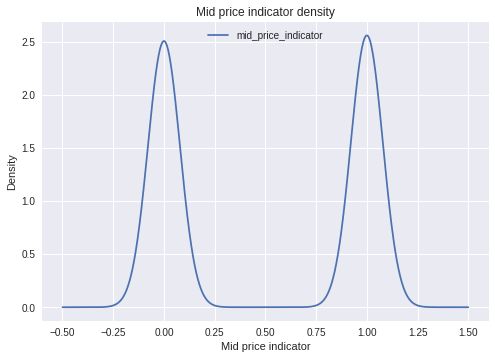

In [6]:
df['mid_price_indicator'].plot('kde')
plt.legend()
plt.xlabel('Mid price indicator')
plt.title('Mid price indicator density')

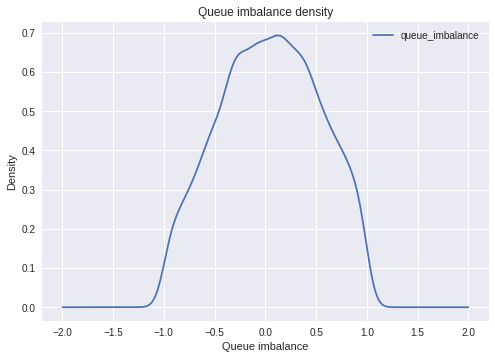

In [7]:
df['queue_imbalance'].plot('kde')
plt.legend()
plt.xlabel('Queue imbalance')
plt.title('Queue imbalance density')

## Tests

We use logistic regression to predict `mid_price_indicator`.

### Mean square error 

We calculate residual $r_i$:

$$ r_i = \hat{y_i} - y_i $$

where 

$$ \hat{y}(I) = \frac{1}{1 + e^{-(x_0 + Ix_1 )}}$$

Calculating mean square residual for all observations in the testing set is also useful to assess the predictive power.

The predective power of null-model is 25%.

In [8]:
reg = lob.logistic_regression(df, 0, len(df))

probabilities = reg.predict_proba(df_test['queue_imbalance'].values.reshape(-1,1))
probabilities = [p1 for p0, p1 in probabilities]
err = ((df_test['mid_price_indicator'] - probabilities) ** 2).mean()

predictions = reg.predict(df_test['queue_imbalance'].values.reshape(-1, 1))

print('Mean square error is', err)

Mean square error is 0.24526884356734996


#### Logistic regression fit curve

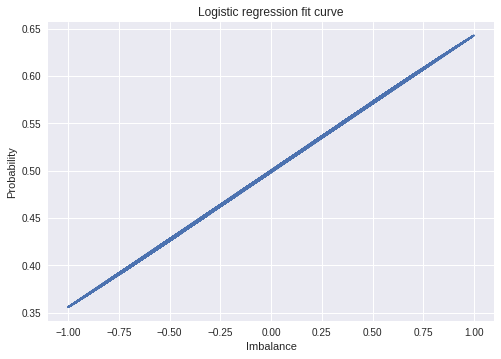

In [12]:
plt.plot(df_test['queue_imbalance'].values, 
         lob.sigmoid(reg.coef_[0] * df_test['queue_imbalance'].values + reg.intercept_))
plt.title('Logistic regression fit curve')
plt.xlabel('Imbalance')
plt.ylabel('Probability')

#### ROC curve

For assessing the predectivity power we can calculate ROC score.

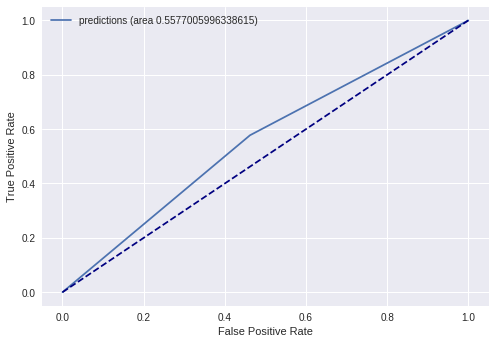

In [10]:
a, b, c = roc_curve(df_test['mid_price_indicator'], predictions)
logit_roc_auc = roc_auc_score(df_test['mid_price_indicator'], predictions)
plt.plot(a, b, label='predictions (area {})'.format(logit_roc_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

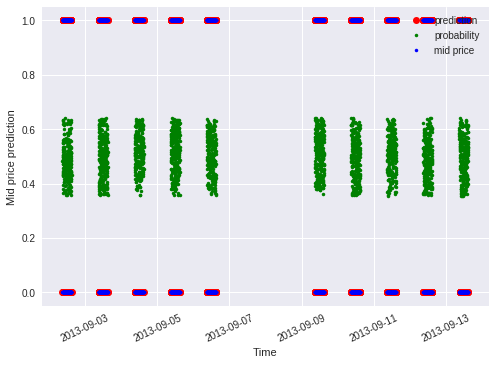

In [11]:
st = 0
end = len(df)
plt.plot(df_test.index[st:end], predictions[st:end], 'ro', label='prediction')
plt.plot(df_test.index[st:end], probabilities[st:end], 'g.', label='probability')
plt.plot(df_test.index[st:end], df_test['mid_price_indicator'].values[st:end], 'b.', label='mid price')
plt.xticks(rotation=25)
plt.legend(loc=1)
plt.xlabel('Time')
plt.ylabel('Mid price prediction')

## Conclusions

Looking at mid_price_indicator density plot it seems that bid and ask queues are balanced. The same conclusion we can get from queue imbalance density plot - most often the queues are balanced.


* predicted probability vs known indicator: 0.245, so it's slightly better than null-model (0.25). 
* area under ROC curve is 0.557, for null-model it's 0.50.

We didn't remove any outliers.

### Resources

1. [Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book](https://arxiv.org/abs/1512.03492) <a class="anchor-link" href="#1">¶</a> 